# BAN-693 : CAPSTONE PROJECT
### Professor : Dr. Chongqi Wu
### Group Members:
##### Sharmila Gowri Velugula - ku3936
##### Shruti Ravindra Joshi - jd4923
##### Suchitra Venkatesan - qw9486
##### Vani Narahari Joshi - eu2388


# DEPRESSIVE TWEETS ANALYSIS

Mental illness such as depression can be life threatening, with suicide as a possible outcome. In this project, a LSTM with CNN and LSTM with GloVe is built using Keras to determine whether twitter users are depressive based on their Twitter posts. The accuracy of the model is evaluated and compared to a Logistic Regression baseline model, TFIDF & Bag-Of-Words models.

### Imports

In [ ]:
import warnings
warnings.filterwarnings("ignore")
import ftfy
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import re

from math import exp
from numpy import sign

from gensim.models import KeyedVectors
from nltk.corpus import stopwords
from nltk import PorterStemmer
from nltk.stem import WordNetLemmatizer

from keras.models import Model, Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Conv1D, Dense, Input, LSTM, Embedding, Dropout, Activation, MaxPooling1D, Bidirectional
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from wordcloud import WordCloud 
import wordcloud

#python basics
from matplotlib import pyplot as plt
import math, os, re, time, random, string
import numpy as np, pandas as pd, seaborn as sns

from tqdm import tqdm

#visualization
import matplotlib.pyplot as plt
plt.style.use('ggplot')   #for optimum aesthetics 
import seaborn as sns

#natural language processing
from collections import defaultdict
# import wordcloud

import warnings
warnings.filterwarnings('ignore')

#for neural nets
import tensorflow as tf

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer
from math import log
from nltk.tokenize import word_tokenize
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report


# from wordcloud import WordCloud 
from textblob import TextBlob

import numpy as np
from PIL import Image


import numpy as np
from PIL import Image


#### Variable declarations:

In [ ]:
np.random.seed(1234)
random_rows = 3100 # number of rows to read from Pos_Tweets.csv
max_seq_length = 140 # Max tweet size
max_words = 20000
embed_dim = 300
train_split = 0.6
test_split = 0.2
learn_rate = 0.1
total_epochs= 10

## 1) LOAD DATA

### Reading the Input Files:

Loading Positive tweets from kaggle dataset

In [ ]:
random_tweets_df = pd.read_csv('Pos_Tweets.csv', encoding = "ISO-8859-1", usecols = range(0,4), nrows = random_rows)
random_tweets_df.head()

,ItemID,Sentiment,SentimentSource,SentimentText
0,3,0,Sentiment140,omg its already 7:30 :O
1,7,0,Sentiment140,Juuuuuuuuuuuuuuuuussssst Chillin!!
2,9,0,Sentiment140,handed in my uniform today . i miss you ...
3,10,0,Sentiment140,hmmmm.... i wonder how she my number @-)
4,12,0,Sentiment140,thanks to all the haters up in my face a...


Loading depressive tweets that are scraped from twitter

In [ ]:
depressive_tweets_df = pd.read_csv('Neg_Tweets.csv', parse_dates= [1])
depressive_tweets_df.head()

,Tweet,Time,User_Location,Sentiment,Retweets
0,@SkySportsPL Jesse Lingard says came close tak...,2021-04-22 21:01:49+00:00,NaN,1,False
1,My parents undeserving title cuz believed kids...,2021-04-22 21:01:53+00:00,"Joondalup, Western Australia",1,False
2,Breathing normally difficulty falling asleep d...,2021-04-22 21:01:55+00:00,"7 Rd., 22/7 Saima Sub-distric,",1,False
3,Fentanyl depression respiration https://t.co/f...,2021-04-22 21:01:55+00:00,"Bukowina Tatrzanska, Poland",1,False
4,@TosinOlugbenga Tweeting situations Nigeria gi...,2021-04-22 21:02:02+00:00,"Ikeja, Lagos",1,False


Loading Pre trained Word2Vec Model 

In [ ]:
word2vec = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary=True)

## 2) DATA PREPROCESSING & EXPLORATORY DATA ANALYSIS

Removing hastags, links and images, @mentions, emoji's, punctuation, stop words, Perform stemming etc

In [ ]:
# Expand Contraction
cList = {
  "ain't": "am not",
  "aren't": "are not",
  "can't": "cannot",
  "can't've": "cannot have",
  "'cause": "because",
  "could've": "could have",
  "couldn't": "could not",
  "couldn't've": "could not have",
  "didn't": "did not",
  "doesn't": "does not",
  "don't": "do not",
  "hadn't": "had not",
  "hadn't've": "had not have",
  "hasn't": "has not",
  "haven't": "have not",
  "he'd": "he would",
  "he'd've": "he would have",
  "he'll": "he will",
  "he'll've": "he will have",
  "he's": "he is",
  "how'd": "how did",
  "how'd'y": "how do you",
  "how'll": "how will",
  "how's": "how is",
  "I'd": "I would",
  "I'd've": "I would have",
  "I'll": "I will",
  "I'll've": "I will have",
  "I'm": "I am",
  "I've": "I have",
  "isn't": "is not",
  "it'd": "it had",
  "it'd've": "it would have",
  "it'll": "it will",
  "it'll've": "it will have",
  "it's": "it is",
  "let's": "let us",
  "ma'am": "madam",
  "mayn't": "may not",
  "might've": "might have",
  "mightn't": "might not",
  "mightn't've": "might not have",
  "must've": "must have",
  "mustn't": "must not",
  "mustn't've": "must not have",
  "needn't": "need not",
  "needn't've": "need not have",
  "o'clock": "of the clock",
  "oughtn't": "ought not",
  "oughtn't've": "ought not have",
  "shan't": "shall not",
  "sha'n't": "shall not",
  "shan't've": "shall not have",
  "she'd": "she would",
  "she'd've": "she would have",
  "she'll": "she will",
  "she'll've": "she will have",
  "she's": "she is",
  "should've": "should have",
  "shouldn't": "should not",
  "shouldn't've": "should not have",
  "so've": "so have",
  "so's": "so is",
  "that'd": "that would",
  "that'd've": "that would have",
  "that's": "that is",
  "there'd": "there had",
  "there'd've": "there would have",
  "there's": "there is",
  "they'd": "they would",
  "they'd've": "they would have",
  "they'll": "they will",
  "they'll've": "they will have",
  "they're": "they are",
  "they've": "they have",
  "to've": "to have",
  "wasn't": "was not",
  "we'd": "we had",
  "we'd've": "we would have",
  "we'll": "we will",
  "we'll've": "we will have",
  "we're": "we are",
  "we've": "we have",
  "weren't": "were not",
  "what'll": "what will",
  "what'll've": "what will have",
  "what're": "what are",
  "what's": "what is",
  "what've": "what have",
  "when's": "when is",
  "when've": "when have",
  "where'd": "where did",
  "where's": "where is",
  "where've": "where have",
  "who'll": "who will",
  "who'll've": "who will have",
  "who's": "who is",
  "who've": "who have",
  "why's": "why is",
  "why've": "why have",
  "will've": "will have",
  "won't": "will not",
  "won't've": "will not have",
  "would've": "would have",
  "wouldn't": "would not",
  "wouldn't've": "would not have",
  "y'all": "you all",
  "y'alls": "you alls",
  "y'all'd": "you all would",
  "y'all'd've": "you all would have",
  "y'all're": "you all are",
  "y'all've": "you all have",
  "you'd": "you had",
  "you'd've": "you would have",
  "you'll": "you you will",
  "you'll've": "you you will have",
  "you're": "you are",
  "you've": "you have",
    "https": " ",
    "co": " ",
    "the": " ",
    "it": " "
}

c_re = re.compile('(%s)' % '|'.join(cList.keys()))

def expandContractions(text, c_re=c_re):
    def replace(match):
        return cList[match.group(0)]
    return c_re.sub(replace, text)

In [ ]:
def clean_tweets(tweets):
    cleaned_tweets = []
    for tweet in tweets:
        tweet = str(tweet)        
        
        if re.match("(\w+:\/\/\S+)", tweet) == None and len(tweet) > 10:
            #removing hashtag, @mention, emoji and image URLs
            tweet = ' '.join(re.sub("(@[A-Za-z0-9]+)|(\#[A-Za-z0-9]+)|(<Emoji:.*>)|(pic\.twitter\.com\/.*)", " ", tweet).split())
            
            #fixing encoded texts
            tweet = ftfy.fix_text(tweet)
            
            #expanding contractions
            tweet = expandContractions(tweet)

            #removing punctuations
            tweet = ' '.join(re.sub("([^0-9A-Za-z \t])", " ", tweet).split())

            #removing stop words
            stop_words = set(stopwords.words('english'))
            word_tokens = nltk.word_tokenize(tweet) 
            filtered_sentence = [w for w in word_tokens if not w in stop_words]
            tweet = ' '.join(filtered_sentence)

            #stemming words
            tweet = PorterStemmer().stem(tweet)
                        
            cleaned_tweets.append(tweet)

    return cleaned_tweets

Applying the above clean function to all the elements in depressive tweets and random tweets

In [ ]:
# Storing the tweets as a list
depressive_tweets_arr = [x for x in depressive_tweets_df['Tweet']]
random_tweets_arr = [x for x in random_tweets_df['SentimentText']]

# Cleaning
X_depressive = clean_tweets(depressive_tweets_arr)
X_random = clean_tweets(random_tweets_arr)

In [ ]:
depressive_tweets_df[:3]

,Tweet,Time,User_Location,Sentiment,Retweets
0,@SkySportsPL Jesse Lingard says came close tak...,2021-04-22 21:01:49+00:00,NaN,1,False
1,My parents undeserving title cuz believed kids...,2021-04-22 21:01:53+00:00,"Joondalup, Western Australia",1,False
2,Breathing normally difficulty falling asleep d...,2021-04-22 21:01:55+00:00,"7 Rd., 22/7 Saima Sub-distric,",1,False


In [ ]:
depressive_tweets_arr[:3]

['@SkySportsPL Jesse Lingard says came close taking timeout football lockdown battled mental health issues …',
 'My parents undeserving title cuz believed kids would fix dysfunctional relatio … https://t.co/8LEWaspoZ6',
 'Breathing normally difficulty falling asleep depression bipolar disorder sleeping well #PurePhonon #PurePhoton … https://t.co/IPxf0fc1N9']

### Data Visualization

##### Most common words

In [ ]:
from collections import Counter

data_set = ' '.join(x for x in X_depressive)
split_it = data_set.split()
Counter = Counter(split_it)
  
# 10 most commonly occuring words
most_occur = Counter.most_common(10)
  
print(most_occur)

[('depression', 1806), ('i', 1343), ('health', 395), ('mental', 337), ('amp', 303), ('depress', 257), ('know', 255), ('anxiety', 244), ('one', 227), ('like', 216)]


#### Common words visualization

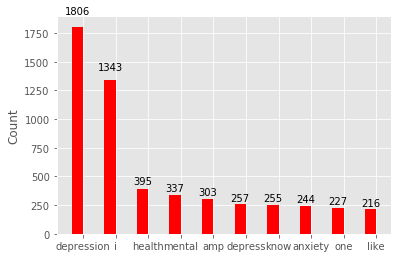

In [ ]:
names, values = zip(*most_occur)  
ind = np.arange(len(most_occur))  
width = 0.35       

fig, ax = plt.subplots()
rects1 = ax.bar(ind, values, width, color='r')

ax.set_ylabel('Count')
ax.set_xticks(ind+width/2.)
ax.set_xticklabels(names)



def autolabel(rects):
    
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                '%d' % int(height),
                ha='center', va='bottom')

autolabel(rects1)

plt.show()

##### Frquency distribution of Top 50 tokens

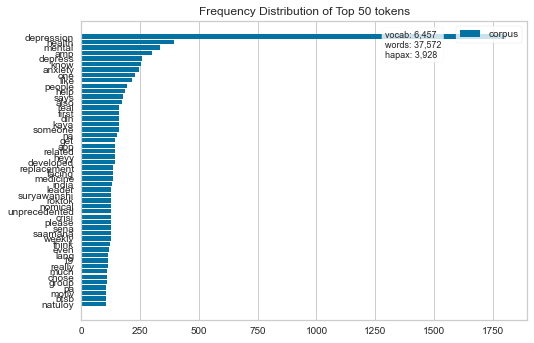

In [ ]:
import yellowbrick
from yellowbrick.text import FreqDistVisualizer
from sklearn.feature_extraction.text import CountVectorizer

stop_words = set(stopwords.words('english'))
vectorizer = CountVectorizer(stop_words=stop_words)
docs = vectorizer.fit_transform(X_depressive)
features = vectorizer.get_feature_names()
visualizer = FreqDistVisualizer(features=features)
visualizer.fit(docs)
visualizer.poof()

##### Polarity of Depressive Tweets for every hour : 

In [ ]:
depressive_tweets_df['polarity']=depressive_tweets_df['Tweet'].apply(lambda x:TextBlob(x).sentiment.polarity)

In [ ]:
# extract date from the datetime object
depressive_tweets_df['houroftweet'] = depressive_tweets_df['Time'].dt.hour
depressive_tweets_df.head()

,Tweet,Time,User_Location,Sentiment,Retweets,polarity,houroftweet
0,@SkySportsPL Jesse Lingard says came close tak...,2021-04-22 21:01:49+00:00,NaN,1,False,-0.10,21
1,My parents undeserving title cuz believed kids...,2021-04-22 21:01:53+00:00,"Joondalup, Western Australia",1,False,0.00,21
2,Breathing normally difficulty falling asleep d...,2021-04-22 21:01:55+00:00,"7 Rd., 22/7 Saima Sub-distric,",1,False,0.15,21
3,Fentanyl depression respiration https://t.co/f...,2021-04-22 21:01:55+00:00,"Bukowina Tatrzanska, Poland",1,False,0.00,21
4,@TosinOlugbenga Tweeting situations Nigeria gi...,2021-04-22 21:02:02+00:00,"Ikeja, Lagos",1,False,-0.10,21


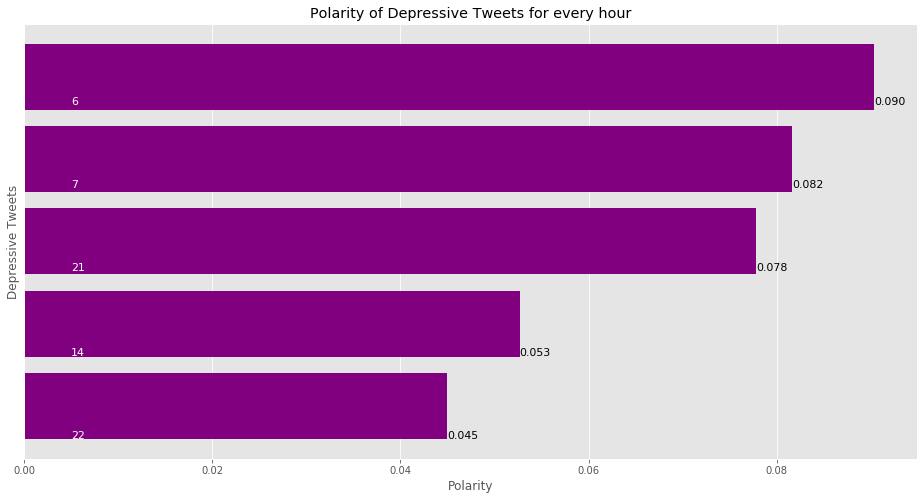

In [ ]:
polarity_sorted=pd.DataFrame(depressive_tweets_df.groupby('houroftweet')['polarity'].mean().sort_values(ascending=True))

plt.figure(figsize=(16,8))
plt.xlabel('Polarity')
plt.ylabel('Depressive Tweets')
plt.title('Polarity of Depressive Tweets for every hour')
polarity_graph=plt.barh(np.arange(len(polarity_sorted.index)),polarity_sorted['polarity'],color='purple',)

for bar,product in zip(polarity_graph,polarity_sorted.index):
  plt.text(0.005,bar.get_y()+bar.get_width(),'{}'.format(product),va='center',fontsize=11,color='white')

for bar,polarity in zip(polarity_graph,polarity_sorted['polarity']):
  plt.text(bar.get_width()+0.00001,bar.get_y()+bar.get_width(),'%.3f'%polarity,va='center',fontsize=11,color='black')
  
plt.yticks([])
plt.show()

#####  Word Cloud  (For negative sentiments)

In [ ]:
image_mask = np.array(Image.open("Sad_1.jpg"))

In [ ]:
# Create a word cloud image
wc = WordCloud(background_color="black", max_words=300, mask=image_mask, #stopwords=stopwords,
               contour_width=1, contour_color='white')

In [ ]:
# Generate a wordcloud
text = ' '.join(review for review in X_depressive)
wc.generate(text)

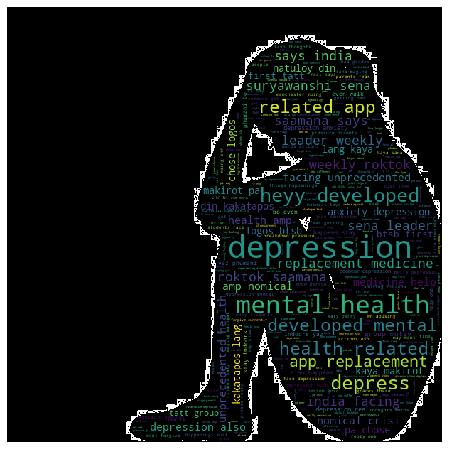

In [ ]:
plt.figure(figsize=[10,8])
plt.imshow(wc, interpolation='nearest')
plt.axis("off")
plt.show()   

##### Word Cloud  (For positive sentiments)

In [ ]:
image_mask = np.array(Image.open("twitter.png"))

In [ ]:
# Create a word cloud image
wc = WordCloud(background_color="white", max_words=300, mask=image_mask,
               contour_width=1, contour_color='blue')

In [ ]:
# Generate a wordcloud
text = ' '.join(review for review in X_random)
wc.generate(text)

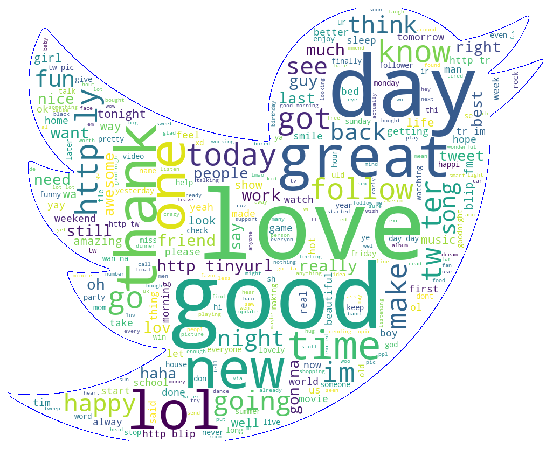

In [ ]:
plt.figure(figsize=[10,8])
plt.imshow(wc, interpolation='nearest')
plt.axis("off")
plt.show()   

### Tokenization


##### Sentence Tokenization - Generating vocabulary index dictionaries based on word frequency. Every word in the sentence is given a unique number:

In [ ]:
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_depressive + X_random)

##### Transforms the above texts into a sequence of integers:

In [ ]:
seq_depressive = tokenizer.texts_to_sequences(X_depressive)
seq_random = tokenizer.texts_to_sequences(X_random)

##### Example displaying the word_index for a random sentence:

In [ ]:
t = Tokenizer()
example_data = [
  "I love coffee.",
  "I like tea.",
  "I dislike milk.",
  "I am going to the supermarket later this morning for some coffee."
]
t.fit_on_texts(example_data)
t.word_index

{'i': 1,
 'coffee': 2,
 'love': 3,
 'like': 4,
 'tea': 5,
 'dislike': 6,
 'milk': 7,
 'am': 8,
 'going': 9,
 'to': 10,
 'the': 11,
 'supermarket': 12,
 'later': 13,
 'this': 14,
 'morning': 15,
 'for': 16,
 'some': 17}

##### Example displaying the word_counts for a random sentence:

In [ ]:
t = Tokenizer()
t.fit_on_texts(example_data)
t.word_counts

OrderedDict([('i', 4),
             ('love', 1),
             ('coffee', 2),
             ('like', 1),
             ('tea', 1),
             ('dislike', 1),
             ('milk', 1),
             ('am', 1),
             ('going', 1),
             ('to', 1),
             ('the', 1),
             ('supermarket', 1),
             ('later', 1),
             ('this', 1),
             ('morning', 1),
             ('for', 1),
             ('some', 1)])

In [ ]:
word_index = tokenizer.word_index
print('Total number of unique tokens = %s ' % len(word_index))

Total number of unique tokens = 11261 


#### pad_sequences
* This function transforms a list of sequences (integers) into a 2-Dimensional Numpy array of shape (number_of_samples, number_of_timesteps).  
* Any sequences shorter than the number_of_timesteps will be padded until they are number_of_timesteps long.
* Any sequences longer than the number_of_timesteps will be truncated so that they fit the desired length.

In [ ]:
data_depressive = pad_sequences(seq_depressive, maxlen=max_seq_length)
data_random = pad_sequences(seq_random, maxlen=max_seq_length)
print('Shape of data_depressive tensor:', data_depressive.shape)
print('Shape of data_random tensor:', data_random.shape)

Shape of data_depressive tensor: (3648, 140)
Shape of data_random tensor: (2939, 140)


### Embedding Matrix

In [ ]:
words = min(max_words+1, len(word_index)+1)

embedding_matrix = np.zeros((words, embed_dim))

for (word, idx) in word_index.items():
    if word in word2vec.vocab and idx < max_words:
        embedding_matrix[idx] = word2vec.word_vec(word)

In [ ]:
print(len(data_depressive))
print(len(data_random))

3648
2939


In [ ]:
depressive_labels = np.array(depressive_tweets_df['Sentiment'])
random_labels = np.array(random_tweets_df['Sentiment'])

### Shuffling, splitting and Formatting the data

##### Random Shuffling

In [ ]:
depressive_perm = np.random.permutation(len(data_depressive))
train_depressive_indx = depressive_perm[:int(len(data_depressive)*(train_split))]
test_depressive_indx = depressive_perm[int(len(data_depressive)*(train_split)):int(len(data_depressive)*(train_split+test_split))]
val_depressive_indx = depressive_perm[int(len(data_depressive)*(train_split+test_split)):]

In [ ]:
random_perm = np.random.permutation(len(data_random))
train_random_indx = random_perm[:int(len(data_random)*(train_split))]
test_random_indx = random_perm[int(len(data_random)*(train_split)):int(len(data_random)*(train_split+test_split))]
val_random_indx = random_perm[int(len(data_random)*(train_split+test_split)):]

##### Data Splitting 

In [ ]:
data_train = np.concatenate((data_depressive[train_depressive_indx], data_random[train_random_indx]))
labels_train = np.concatenate((depressive_labels[train_depressive_indx], random_labels[train_random_indx]))
data_test = np.concatenate((data_depressive[test_depressive_indx], data_random[test_random_indx]))
labels_test = np.concatenate((depressive_labels[test_depressive_indx], random_labels[test_random_indx]))
data_val = np.concatenate((data_depressive[val_depressive_indx], data_random[val_random_indx]))
labels_val = np.concatenate((depressive_labels[val_depressive_indx], random_labels[val_random_indx]))

##### Shuffling the split data:

In [ ]:
perm_train = np.random.permutation(len(data_train))
data_train = data_train[perm_train]
labels_train = labels_train[perm_train]
perm_test = np.random.permutation(len(data_test))
data_test = data_test[perm_test]
labels_test = labels_test[perm_test]
perm_val = np.random.permutation(len(data_val))
data_val = data_val[perm_val]
labels_val = labels_val[perm_val]

## 3) BUILDING MODELS

### Model -1: Logistic Regression [BaseLine Model]

In [ ]:
class LogReg:
    """
    Class to represent a logistic regression model.
    """

    def __init__(self, l_rate, total_epochs, n_features):       
        
        self.l_rate = l_rate
        self.total_epochs = total_epochs
        self.coef = [0.0] * n_features
        self.bias = 0.0

    def sigmoid(self, score, threshold=20.0):
        
        if abs(score) > threshold:
            score = threshold * sign(score)
        activation = exp(score)
        return activation / (1.0 + activation)

    def predict(self, features):        
        value = sum([features[i]*self.coef[i] for i in range(len(features))]) + self.bias
        return self.sigmoid(value)

    def sg_update(self, features, label):
        
        yhat = self.predict(features)
        e = label - yhat
        self.bias = self.bias + self.l_rate * e * yhat * (1-yhat)
        for i in range(len(features)):
            self.coef[i] = self.coef[i] + self.l_rate * e * yhat * (1-yhat) * features[i]
        return

    def train(self, X, y):
        
        for epoch in range(self.total_epochs):
            for features, label in zip(X, y):
                self.sg_update(features, label)
        return self.bias, self.coef

In [ ]:
def precision_m(y_bar, y_pred):
    true_positives = K.sum(K.round(K.clip(y_bar * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

In [ ]:
# Logistic Model
logreg = LogReg(learn_rate, total_epochs, len(data_train[0]))
bias_logreg, weights_logreg = logreg.train(data_train, labels_train)
y_logistic = [round(logreg.predict(example)) for example in data_test]

##### Logistic Regression Model Performance Metrics:

In [ ]:
print('Logistic Regression Model Accuracy:', accuracy_score(y_logistic, labels_test))
print('Logistic Regression Model Precision:', precision_score(y_logistic, labels_test))
print('Logistic Regression Model Recall:', recall_score(y_logistic, labels_test))
print('Logistic Regression Model F1 Score:', f1_score(y_logistic, labels_test))

Logistic Regression Model Accuracy: 0.5599393019726859
Logistic Regression Model Precision: 1.0
Logistic Regression Model Recall: 0.5572519083969466
Logistic Regression Model F1 Score: 0.715686274509804


### Model -2 : TFIDF and BOW

In [ ]:
df1 = random_tweets_df[["Sentiment", "SentimentText"]]
df2 = depressive_tweets_df[["Sentiment","Tweet"]]
df1.columns=["Sentiment", "Tweet"]
df1.head()

,Sentiment,Tweet
0,0,omg its already 7:30 :O
1,0,Juuuuuuuuuuuuuuuuussssst Chillin!!
2,0,handed in my uniform today . i miss you ...
3,0,hmmmm.... i wonder how she my number @-)
4,0,thanks to all the haters up in my face a...


In [ ]:
df2.head()

,Sentiment,Tweet
0,1,@SkySportsPL Jesse Lingard says came close tak...
1,1,My parents undeserving title cuz believed kids...
2,1,Breathing normally difficulty falling asleep d...
3,1,Fentanyl depression respiration https://t.co/f...
4,1,@TosinOlugbenga Tweeting situations Nigeria gi...


In [ ]:
TFBW_df = pd.concat([df1,df2])
TFBW_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6702 entries, 0 to 3682
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Sentiment  6702 non-null   int64 
 1   Tweet      6702 non-null   object
dtypes: int64(1), object(1)
memory usage: 157.1+ KB


In [ ]:
df_train, df_test = train_test_split(TFBW_df, test_size=1-0.8, random_state=42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))
df_train['Sentiment'].value_counts()

TRAIN size: 5361
TEST size: 1341


1    2960
0    2401
Name: Sentiment, dtype: int64

In [ ]:
def process_message(message, lower_case = True, stem = True, stop_words = True, gram = 2):
    if lower_case:
        message = message.lower()
    words = word_tokenize(message)
    words = [w for w in words if len(w) > 2]
    if gram > 1:
        w = []
        for i in range(len(words) - gram + 1):
            w += [' '.join(words[i:i + gram])]
        return w
    if stop_words:
        sw = stopwords.words('english')
        words = [word for word in words if word not in sw]
    if stem:
        stemmer = PorterStemmer()
        words = [stemmer.stem(word) for word in words]   
    return words


class TweetClassifier(object):
    def __init__(self, df_train, method = 'tf-idf'):
        self.tweets, self.labels = df_train['Tweet'], df_train['Sentiment']
        self.method = method

    def train(self):
        self.calc_TF_and_IDF()
        if self.method == 'tf-idf':
            self.calc_TF_IDF()
        else:
            self.calc_prob()

    def calc_prob(self):
        self.prob_depressive = dict()
        self.prob_positive = dict()
        for word in self.tf_depressive:
            self.prob_depressive[word] = (self.tf_depressive[word] + 1) / (self.depressive_words + \
                                                                len(list(self.tf_depressive.keys())))
        for word in self.tf_positive:
            self.prob_positive[word] = (self.tf_positive[word] + 1) / (self.positive_words + \
                                                                len(list(self.tf_positive.keys())))
        self.prob_depressive_tweet, self.prob_positive_tweet = self.depressive_tweets / self.total_tweets, self.positive_tweets / self.total_tweets 


    def calc_TF_and_IDF(self):
        noOfMessages = self.tweets.shape[0]
        self.depressive_tweets, self.positive_tweets = self.labels.value_counts()[0], self.labels.value_counts()[1]
        self.total_tweets = self.depressive_tweets + self.positive_tweets
        self.depressive_words = 0
        self.positive_words = 0
        self.tf_depressive = dict()
        self.tf_positive = dict()
        self.idf_depressive = dict()
        self.idf_positive = dict()
        for i in range(noOfMessages):
            message_processed = process_message(self.tweets.iloc[i])
            count = list() 
            for word in message_processed:
                if self.labels.iloc[i]:
                    self.tf_depressive[word] = self.tf_depressive.get(word, 0) + 1
                    self.depressive_words += 1
                else:
                    self.tf_positive[word] = self.tf_positive.get(word, 0) + 1
                    self.positive_words += 1
                if word not in count:
                    count += [word]
            for word in count:
                if self.labels.iloc[i]:
                    self.idf_depressive[word] = self.idf_depressive.get(word, 0) + 1
                else:
                    self.idf_positive[word] = self.idf_positive.get(word, 0) + 1

    def calc_TF_IDF(self):
        self.prob_depressive = dict()
        self.prob_positive = dict()
        self.sum_tf_idf_depressive = 0
        self.sum_tf_idf_positive = 0
        for word in self.tf_depressive:
            self.prob_depressive[word] = (self.tf_depressive[word]) * log((self.depressive_tweets + self.positive_tweets) \
                                                          / (self.idf_depressive[word] + self.idf_positive.get(word, 0)))
            self.sum_tf_idf_depressive += self.prob_depressive[word]
        for word in self.tf_depressive:
            self.prob_depressive[word] = (self.prob_depressive[word] + 1) / (self.sum_tf_idf_depressive + len(list(self.prob_depressive.keys())))
            
        for word in self.tf_positive:
            self.prob_positive[word] = (self.tf_positive[word]) * log((self.depressive_tweets + self.positive_tweets) \
                                                          / (self.idf_depressive.get(word, 0) + self.idf_positive[word]))
            self.sum_tf_idf_positive += self.prob_positive[word]
        for word in self.tf_positive:
            self.prob_positive[word] = (self.prob_positive[word] + 1) / (self.sum_tf_idf_positive + len(list(self.prob_positive.keys())))
            
    
        self.prob_depressive_tweet, self.prob_positive_tweet = self.depressive_tweets / self.total_tweets, self.positive_tweets / self.total_tweets 
                    
    def classify(self, processed_message):
        pDepressive, pPositive = 0, 0
        for word in processed_message:                
            if word in self.prob_depressive:
                pDepressive += log(self.prob_depressive[word])
            else:
                if self.method == 'tf-idf':
                    pDepressive -= log(self.sum_tf_idf_depressive + len(list(self.prob_depressive.keys())))
                else:
                    pDepressive -= log(self.depressive_words + len(list(self.prob_depressive.keys())))
            if word in self.prob_positive:
                pPositive += log(self.prob_positive[word])
            else:
                if self.method == 'tf-idf':
                    pPositive -= log(self.sum_tf_idf_positive + len(list(self.prob_positive.keys()))) 
                else:
                    pPositive -= log(self.positive_words + len(list(self.prob_positive.keys())))
            pDepressive += log(self.prob_depressive_tweet)
            pPositive += log(self.prob_positive_tweet)
        return pDepressive >= pPositive
    
    def predict(self, df_test):
        result = dict()
        for (i, message) in enumerate(df_test):
            processed_message = process_message(message)
            result[i] = int(self.classify(processed_message))
        return result  
    


In [ ]:
def metrics(labels, predictions):
    true_pos, true_neg, false_pos, false_neg = 0, 0, 0, 0
    for i in range(len(labels)):
        true_pos += int(labels.iloc[i] == 1 and predictions[i] == 1)
        true_neg += int(labels.iloc[i] == 0 and predictions[i] == 0)
        false_pos += int(labels.iloc[i] == 0 and predictions[i] == 1)
        false_neg += int(labels.iloc[i] == 1 and predictions[i] == 0)
    
    try:
        precision = true_pos / (true_pos + false_pos)
    except ZeroDivisionError:
        precision = 0
    try:    
        recall = true_pos / (true_pos + false_neg)
    except ZeroDivisionError:
        recall = 0
    try:
        Fscore = 2 * precision * recall / (precision + recall)
    except ZeroDivisionError:
        Fscore = 0
        
    try:
        accuracy = (true_pos + true_neg) / (true_pos + true_neg + false_pos + false_neg)
    except ZeroDivisionError:
        accuracy = 0
        
    print("Precision: ", precision)
    print("Recall: ", recall)
    print("F-score: ", Fscore)
    print("Accuracy: ", accuracy)

#### TF-IDF Performance Metrics:

In [ ]:
sc_tf_idf = TweetClassifier(df_train, 'tf-idf')
sc_tf_idf.train()
preds_tf_idf = sc_tf_idf.predict(df_test['Tweet'])
metrics(df_test['Sentiment'], preds_tf_idf)

Precision:  0.9334532374100719
Recall:  0.7178423236514523
F-score:  0.8115715402658328
Accuracy:  0.8202833706189411


#### BOW Performance Metrics:

In [ ]:
sc_bow = TweetClassifier(df_train, 'bow')
sc_bow.train()
preds_bow = sc_bow.predict(df_test['Tweet'])
metrics(df_test['Sentiment'], preds_bow)

Precision:  0.9402985074626866
Recall:  0.6099585062240664
F-score:  0.7399328859060403
Accuracy:  0.7688292319164802


#### Predictions with TF-IDF

##### Depressive Tweets

In [ ]:
pm = clean_tweets('Lately I have been feeling unsure of myself as a person & an artist')
sc_tf_idf.classify(pm)

True

In [ ]:
pm = clean_tweets('Extreme sadness, lack of energy, hopelessness')
sc_tf_idf.classify(pm)

True

In [ ]:
pm = clean_tweets('Hi hello depression and anxiety are the worst')
sc_tf_idf.classify(pm)

True

##### Positive Tweets

In [ ]:
pm = clean_tweets('Loving how me and my lovely partner is talking about what we want.')
sc_tf_idf.classify(pm)

True

In [ ]:
pm = 'I am happy'
sc_tf_idf.classify(pm)

False

In [ ]:
pm = clean_tweets('Very rewarding when a patient hugs you and tells you they feel great after changing the diet and daily habits')
sc_tf_idf.classify(pm)

True

#### Predictions with Bag-of-Words (BOW)

##### Depressive tweets

In [ ]:
pm = clean_tweets('Hi hello depression and anxiety are the worst')
sc_bow.classify(pm)

True

In [ ]:
pm = clean_tweets('My depression will not let me work out')
sc_bow.classify(pm)

True

In [ ]:
pm = clean_tweets('Feeling down...')
sc_bow.classify(pm)

True

##### Positive Tweets

In [ ]:
pm = clean_tweets('Loving how me and my lovely partner is talking about what we want.')
sc_bow.classify(pm)

True

In [ ]:
pm = clean_tweets('Happy Thursday everyone. Thought today was Wednesday so super happy tomorrow is Friday yayyyyy')
sc_bow.classify(pm)

True

In [ ]:
pm = clean_tweets('I am Happy')
sc_bow.classify(pm)

True

### Model - 3 : CNN + LSTM


This model takes input sentences and replaces them with their embeddings, then runs the new embedding vector through a CNN layer. CNN learns some structure from the sequential data and then passes it into an LSTM layer. The output of the LSTM layer is then fed into a standard Dense layer for prediction.

#### Hyperparameters Tuning:


In [ ]:
model = Sequential()

# Embedding layer
model.add(Embedding(len(embedding_matrix), embed_dim, weights=[embedding_matrix], 
                            input_length=max_seq_length, trainable=False))

# Convolutional Layer
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.2))

# LSTM Layer
model.add(Bidirectional(LSTM(units=200, return_sequences=True)))
model.add(Bidirectional(LSTM(units=200, return_sequences=False)))
model.add(Dropout(0.4))
model.add(Dense(1, activation='sigmoid'))

#### Model Compilation:
#### Performance Metrics considered are: Accuracy, Precision and Recall

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=(['acc'],
             tf.keras.metrics.Precision(), tf.keras.metrics.Recall()))
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 140, 300)          3378600   
_________________________________________________________________
conv1d (Conv1D)              (None, 140, 32)           28832     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 70, 32)            0         
_________________________________________________________________
dropout (Dropout)            (None, 70, 32)            0         
_________________________________________________________________
bidirectional (Bidirectional (None, 70, 400)           372800    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 400)               961600    
_________________________________________________________________
dropout_1 (Dropout)          (None, 400)               0

#### Model Training:

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=2)

hist = model.fit(data_train, labels_train, \
        validation_data=(data_val, labels_val), \
        epochs=total_epochs, batch_size=40, shuffle=True, \
        callbacks=[early_stop], verbose=2)

Epoch 1/10
99/99 - 37s - loss: 0.2975 - acc: 0.8689 - precision: 0.8728 - recall: 0.8935 - val_loss: 0.1826 - val_acc: 0.9249 - val_precision: 0.9817 - val_recall: 0.8808
Epoch 2/10
99/99 - 31s - loss: 0.1543 - acc: 0.9443 - precision: 0.9708 - recall: 0.9273 - val_loss: 0.1618 - val_acc: 0.9378 - val_precision: 0.9513 - val_recall: 0.9356
Epoch 3/10
99/99 - 34s - loss: 0.1012 - acc: 0.9658 - precision: 0.9835 - recall: 0.9543 - val_loss: 0.1759 - val_acc: 0.9416 - val_precision: 0.9618 - val_recall: 0.9315
Epoch 4/10
99/99 - 31s - loss: 0.0748 - acc: 0.9732 - precision: 0.9851 - recall: 0.9662 - val_loss: 0.1691 - val_acc: 0.9469 - val_precision: 0.9728 - val_recall: 0.9301


#### Model Plots:

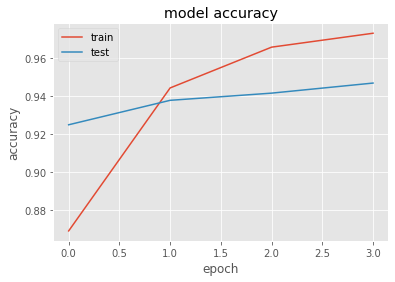

In [ ]:
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

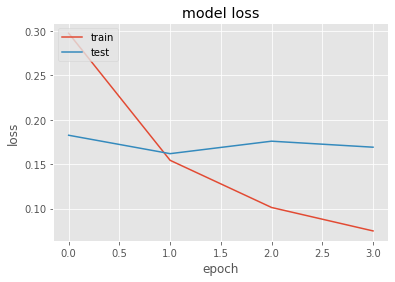

In [ ]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

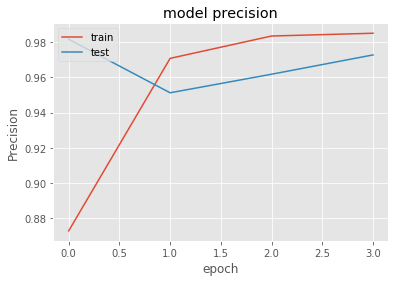

In [ ]:
plt.plot(hist.history['precision'])
plt.plot(hist.history['val_precision'])
plt.title('model precision')
plt.ylabel('Precision')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

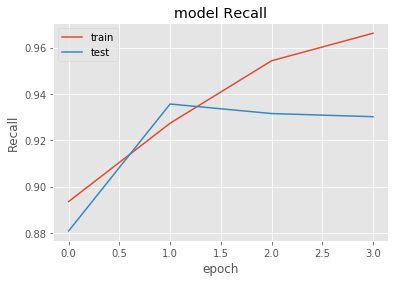

In [ ]:
plt.plot(hist.history['recall'])
plt.plot(hist.history['val_recall'])
plt.title('model Recall')
plt.ylabel('Recall')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### Model Performance Metrics:

In [ ]:
labels_pred = model.predict(data_test)
labels_pred = np.round(labels_pred.flatten())
accuracy = accuracy_score(labels_test, labels_pred)
print("Accuracy: %.2f%%" % (accuracy*100))

Accuracy: 92.79%


In [ ]:
print(classification_report(labels_test, labels_pred))

              precision    recall  f1-score   support

           0       0.88      0.96      0.92       588
           1       0.97      0.90      0.93       730

    accuracy                           0.93      1318
   macro avg       0.93      0.93      0.93      1318
weighted avg       0.93      0.93      0.93      1318



In [ ]:
labels_pred = (model.predict(data_test) > 0.5).astype("int32")
labels_pred[:10]

array([[0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0]], dtype=int32)

In [ ]:
labels_test[:10]

array([0, 0, 1, 0, 1, 1, 1, 0, 0, 0])

#### Confusion Matrix:

In [ ]:
def plot_cm(y_true, y_pred, title, figsize=(5,5)):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true)[::-1])
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_true)[::-1], columns=np.unique(y_true)[::-1])
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    plt.title(title)
    sns.heatmap(cm, cmap= "mako", annot=annot, fmt='', ax=ax)

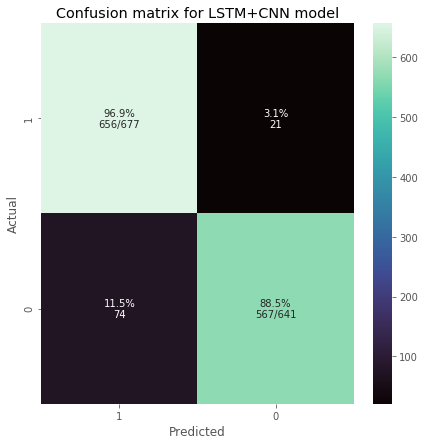

In [ ]:
plot_cm(labels_pred, labels_test, 'Confusion matrix for LSTM+CNN model', figsize=(7,7))

#### Model Evaluation:

In [ ]:
for i,j in zip(X_depressive[1:10], labels_pred[1:10]):
    print("Tweet: ", i)
    if j==1:
        print("The category is = ", j, "implying that it is a Depression related tweet \n")
    else:
        print("The category is = ", j, "implying that it is not a Depression related tweet \n")

Tweet:  my parents undeserving le cuz believed kids would fix dysfunctional relatio 8lewaspoz6
The category is =  [0] implying that it is not a Depression related tweet 

Tweet:  breathing normally difficulty falling asleep depression bipolar disorder sleeping well ipxf0fc1n9
The category is =  [1] implying that it is a Depression related tweet 

Tweet:  fentanyl depression respiration frs37kvwch
The category is =  [0] implying that it is not a Depression related tweet 

Tweet:  tweeting uations nigeria give mental depression just check pages newspaper kidna
The category is =  [1] implying that it is a Depression related tweet 

Tweet:  the sunshine state kids school since last october the states still closed need open rveexmaw5c
The category is =  [1] implying that it is a Depression related tweet 

Tweet:  ac rding survey i take class rapeutic modal best su existentialist i c bkwlswldm4
The category is =  [1] implying that it is a Depression related tweet 

Tweet:  when yo girl think

### Model - 3 : LSTM with GLoVE

In [ ]:
train = depressive_tweets_df
test = random_tweets_df

train = train.sample(frac=1).reset_index(drop=True)
test = test.sample(frac=1).reset_index(drop=True)

train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3683 entries, 0 to 3682
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype              
---  ------         --------------  -----              
 0   Tweet          3683 non-null   object             
 1   Time           3683 non-null   datetime64[ns, UTC]
 2   User_Location  2377 non-null   object             
 3   Sentiment      3683 non-null   int64              
 4   Retweets       3683 non-null   bool               
 5   polarity       3683 non-null   float64            
 6   houroftweet    3683 non-null   int64              
dtypes: bool(1), datetime64[ns, UTC](1), float64(1), int64(2), object(2)
memory usage: 176.4+ KB


In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3019 entries, 0 to 3018
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   ItemID           3019 non-null   int64 
 1   Sentiment        3019 non-null   int64 
 2   SentimentSource  3019 non-null   object
 3   SentimentText    3019 non-null   object
dtypes: int64(2), object(2)
memory usage: 94.5+ KB


In [ ]:
train.columns = ["text", "date","location","target","retweet","polarity","houroftweet"]
print(train.head())

test.columns = ["id", "target", "source", "text"]
test.head()

                                                text  \
0          Peak depression working Phoebe Bridgehard   
1  @MPRnews Hester Ford died earlier month either...   
2  @REALpunknews Shit I Guess My Depression Wasn ...   
3  @RishiSinghani12 @cancell12board @anubha1812 @...   
4  @LEAD_Coalition Please re-Tweet raise awarenes...   

                       date                 location  target  retweet  \
0 2021-04-22 21:26:05+00:00                    miami       1    False   
1 2021-04-25 14:29:20+00:00  Cannon Falls, Minnesota       1    False   
2 2021-04-25 14:10:58+00:00                      NaN       1    False   
3 2021-04-25 14:22:48+00:00                      NaN       1    False   
4 2021-04-22 22:05:54+00:00               ☀️ chasing       1    False   

   polarity  houroftweet  
0  0.000000           21  
1  0.033333           14  
2 -0.200000           14  
3  0.200000           14  
4  0.000000           22  


,id,target,source,text
0,3842,0,Sentiment140,"just noticed that it's #UnfollowSunday , we a..."
1,7408,0,Sentiment140,#iremember that smell of christmas morning..ne...
2,1944,0,Sentiment140,getting ready for school. after i print out t...
3,3194,0,Sentiment140,"- Ok, how about just pray for mental clarity w..."
4,5712,0,Sentiment140,#goodsex is when his intentional training of y...


In [ ]:
#save ID
test_id = test['id']

#drop from train and test
columns = {'source'}
test = test.drop(columns = columns)

cols = {"date","location","retweet"}
train = train.drop(columns = cols)

In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3019 entries, 0 to 3018
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      3019 non-null   int64 
 1   target  3019 non-null   int64 
 2   text    3019 non-null   object
dtypes: int64(2), object(1)
memory usage: 70.9+ KB


In [ ]:
train = train[["target","text"]]

train['target'] = train.target.astype(int)

train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3683 entries, 0 to 3682
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   target  3683 non-null   int64 
 1   text    3683 non-null   object
dtypes: int64(1), object(1)
memory usage: 57.7+ KB


In [ ]:
print('There are', len(train), 'rows in the train set')
print('There are', len(test), 'rows in the test set')

There are 3683 rows in the train set
There are 3019 rows in the test set


In [ ]:
total = train.append(test)

total = total.sample(frac=1).reset_index(drop=True)

total.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6702 entries, 0 to 6701
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   target  6702 non-null   int64  
 1   text    6702 non-null   object 
 2   id      3019 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 157.2+ KB


#### Distribution of Target classes

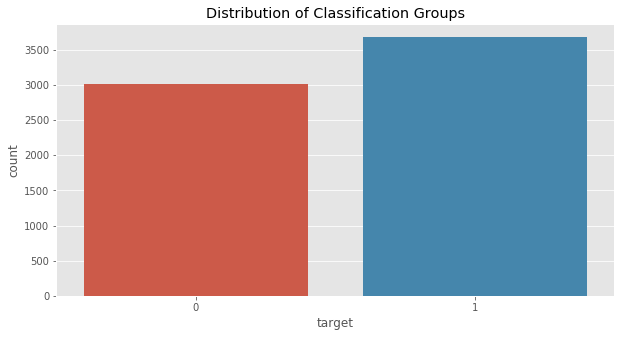

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')   #for optimum aesthetics 
import seaborn as sns

fig, ax = plt.subplots(figsize = (10, 5))

graph1 = sns.countplot(x = 'target', data = total)

plt.title('Distribution of Classification Groups')
plt.show(graph1)


#### Text Processing

In [ ]:

def remove_punctuation(x):
    return x.translate(str.maketrans('', '', string.punctuation))

def remove_stopwords(x):
    return ' '.join([i for i in x.split() if i not in wordcloud.STOPWORDS])

#remove words less than 4 
def remove_less_than(x):
    return ' '.join([i for i in x.split() if len(i) > 3])

def remove_non_alphabet(x):
    return ' '.join([i for i in x.split() if i.isalpha()])

def strip_all_entities(x):
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",x).split())

def remove_hashtag(x):
    return " ".join(word.strip() for word in re.split('#|_', x))

#### Spell Check

In [ ]:
from autocorrect import Speller 

#create function to spell check strings
def spell_check(x):
    spell = Speller(lang='en')
    return " ".join([spell(i) for i in x.split()])

#spellcheck 
mispelled = 'Pleaze spelcheck this sentince'
spell_check(mispelled)

'Please spelcheck this sentence'

#### Applying the Text Pre-Processing to the dataset 

In [ ]:
import string

total['text'] = total['text'].apply(lambda x: x.lower())
total['text'] = total['text'].apply(lambda x: re.sub(r'https?://\S+|www\.\S+', '', x, flags = re.MULTILINE))
total['text'] = total['text'].apply(lambda x: re.sub(r'http?://\S+|www\.\S+', '', x, flags = re.MULTILINE))
total['text'] = total['text'].apply(remove_punctuation)
total['text'] = total['text'].apply(remove_stopwords)
total['text'] = total['text'].apply(remove_less_than)
total['text'] = total['text'].apply(remove_non_alphabet)
total['text'] = total['text'].apply(remove_hashtag)
#total['text'] = total['text'].apply(spell_check)    

#### Validating the expand_contractions function

In [ ]:
expandContractions("can't stop won't stop")

'cannot stop will not stop'

In [ ]:
total['text'] = total['text'].apply(expandContractions)

#### DATA PARTITION

In [ ]:
tweets = [tweet for tweet in total['text']]
train = total[:len(train)]
test = total[len(train):]

In [ ]:
from keras.preprocessing.text import Tokenizer

#Tokenize punctuation
to_exclude = '*+-/()#?!%\n[\\]{|}^_`~\t'
to_tokenize = '!"#$&?:;<=>@'
tokenizer = Tokenizer(filters = to_exclude)
text = 'Why are you so %#@ing angry all the time?!'
text = re.sub(r'(['+to_tokenize+'])', r' \1 ', text)
tokenizer.fit_on_texts([text])

print(tokenizer.word_index)

{'why': 1, 'are': 2, 'you': 3, 'so': 4, '@': 5, 'ing': 6, 'angry': 7, 'all': 8, 'the': 9, 'time': 10}


#### Tokenization

In [ ]:
from keras.preprocessing.sequence import pad_sequences
from keras import Input

#defining tokenizer options
tokenizer = Tokenizer()     
tokenizer.fit_on_texts(tweets)
sequences = tokenizer.texts_to_sequences(tweets)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences)
labels = train['target']
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

nlp_train = data[:len(train)]
labels = labels
nlp_test = data[len(train):]

MAX_SEQUENCE_LENGTH = data.shape[1]

Found 12399 unique tokens.
Shape of data tensor: (6702, 31)
Shape of label tensor: (3683,)


In [ ]:
labels_glove = test["target"]
len(labels_glove)

3019

#### We have used Wikipedia GloVe embeddings

In [ ]:
embeddings_index = {}
with open('glove.6B.300d.txt','r') as f:
    for line in tqdm(f):
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
f.close()

print('Found %s word vectors in the GloVe library' % len(embeddings_index))

400000it [00:26, 14909.48it/s]

Found 400000 word vectors in the GloVe library


In [ ]:
EMBEDDING_DIM = 300   
#initializing embedding matrix with zeros
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))

#adding glove word encodings to library
for word, i in tqdm(word_index.items()):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        
        #words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
        
print("Our embedded matrix is of dimension", embedding_matrix.shape)

100%|██████████| 12399/12399 [00:00<00:00, 400292.30it/s]

Our embedded matrix is of dimension (12400, 300)


In [ ]:
from keras.layers import Embedding, LSTM, Dense, SpatialDropout1D, Bidirectional, Dropout, Concatenate, LeakyReLU, GRU
from keras import Input, Model, regularizers
from keras.optimizers import Adam, SGD, RMSprop
from keras.models import Sequential
from keras.callbacks import EarlyStopping

embedding = Embedding(len(word_index) + 1, EMBEDDING_DIM, weights = [embedding_matrix],
                     input_length = MAX_SEQUENCE_LENGTH, trainable = False)  


In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

def scale(df, scaler):
    return scaler.fit_transform(df.iloc[:, 0:1])

meta_train = scale(train, StandardScaler())
meta_test = scale(test, StandardScaler())

#### We will now design a Long Short-Term Memory (LSTM) recurrent neural network to classify our tweets to see how it performs on the leaderboard

In [ ]:
#function to create lstm model
def create_lstm(spatial_dropout, dropout, recurrent_dropout, learning_rate, bidirectional = False):
    #define activation
    activation = LeakyReLU(alpha = 0.01)
    
    #define inputs
    nlp_input = Input(shape = (MAX_SEQUENCE_LENGTH,), name = 'nlp_input')
    meta_input_train = Input(shape = (1, ), name = 'meta_train')
    emb = embedding(nlp_input)
    emb = SpatialDropout1D(dropout)(emb)

    #add LSTM layer
    if bidirectional:
        nlp_out = (Bidirectional(LSTM(100, dropout = dropout, recurrent_dropout = recurrent_dropout,
                                 kernel_initializer = 'orthogonal')))(emb)
    else:
        nlp_out = (LSTM(100, dropout = dropout, recurrent_dropout = recurrent_dropout,
                                 kernel_initializer = 'orthogonal'))(emb)        
     
    #add meta data    
    x = Concatenate()([nlp_out, meta_input_train])
    
    #add output layer
    x = Dropout(dropout)(x)
    preds = Dense(1, activation='sigmoid', kernel_regularizer = regularizers.l2(1e-4))(x)
    
    #compile model
    model = Model(inputs=[nlp_input , meta_input_train], outputs = preds)
    optimizer = Adam(learning_rate = learning_rate)
    model.compile(loss = 'binary_crossentropy', optimizer = optimizer, 
                  metrics = (['accuracy'], tf.keras.metrics.Precision(), tf.keras.metrics.Recall()))
    
    return model


#define training function to visualize learning curves
def plot_learning_curves(history): 
    fig, ax = plt.subplots(1, 2, figsize = (20, 10))

    ax[0].plot(history.history['accuracy'])
    ax[0].plot(history.history['val_accuracy'])

    ax[1].plot(history.history['loss'])
    ax[1].plot(history.history['val_loss'])

    ax[0].legend(['train', 'validation'], loc = 'upper left')
    ax[1].legend(['train', 'validation'], loc = 'upper left')

    fig.suptitle("Model Accuracy", fontsize=14)

    ax[0].set_ylabel('Accuracy')
    ax[0].set_xlabel('Epoch')
    ax[1].set_ylabel('Loss')
    ax[1].set_xlabel('Epoch')

    return plt.show()

#### Model compilation 

In [ ]:
lstm = create_lstm(spatial_dropout = .2, dropout = .2, recurrent_dropout = .2,
                     learning_rate = 2e-4, bidirectional = True)
lstm.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
nlp_input (InputLayer)          [(None, 31)]         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 31, 300)      3720000     nlp_input[0][0]                  
__________________________________________________________________________________________________
spatial_dropout1d (SpatialDropo (None, 31, 300)      0           embedding_1[0][0]                
__________________________________________________________________________________________________
bidirectional_2 (Bidirectional) (None, 200)          320800      spatial_dropout1d[0][0]          
_______________________________________________________________________________________

In [ ]:
#fit model
history1 = lstm.fit([nlp_train, meta_train], labels, validation_split = .2,
                       epochs = 10, batch_size = 32, verbose = 1)

Epoch 1/10
99/99 [==============================] - 7s 74ms/step - loss: 0.4978 - accuracy: 0.7858 - precision_1: 0.7795 - recall_1: 0.8554 - val_loss: 0.2436 - val_accuracy: 0.9077 - val_precision_1: 0.9578 - val_recall_1: 0.8747
Epoch 2/10
99/99 [==============================] - 7s 67ms/step - loss: 0.2421 - accuracy: 0.9012 - precision_1: 0.9420 - recall_1: 0.8756 - val_loss: 0.2010 - val_accuracy: 0.9159 - val_precision_1: 0.9862 - val_recall_1: 0.8627
Epoch 3/10
99/99 [==============================] - 7s 73ms/step - loss: 0.1996 - accuracy: 0.9209 - precision_1: 0.9593 - recall_1: 0.8952 - val_loss: 0.1587 - val_accuracy: 0.9389 - val_precision_1: 0.9793 - val_recall_1: 0.9108
Epoch 4/10
99/99 [==============================] - 7s 71ms/step - loss: 0.1829 - accuracy: 0.9287 - precision_1: 0.9629 - recall_1: 0.9062 - val_loss: 0.1397 - val_accuracy: 0.9498 - val_precision_1: 0.9846 - val_recall_1: 0.9253
Epoch 5/10
99/99 [==============================] - 7s 73ms/step - loss: 0.1

#### Model Accuracy Plots

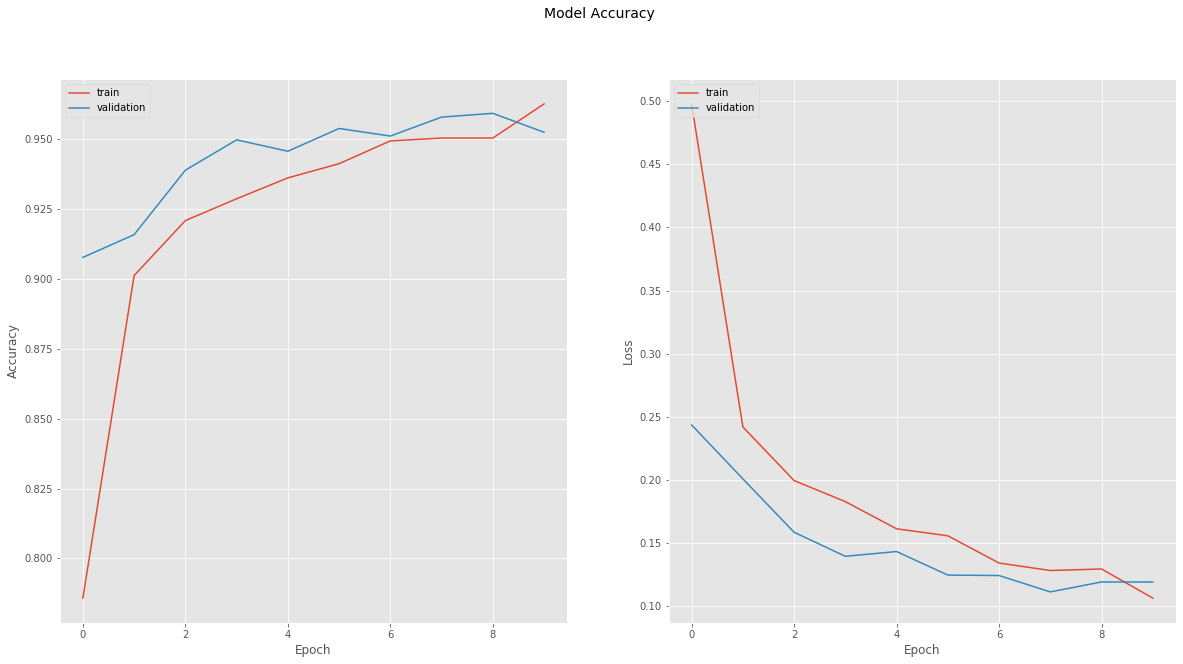

In [ ]:
plot_learning_curves(history1)

#### Model Performance Metrics

In [ ]:
glove_pred = lstm.predict([nlp_test, meta_test])
glove_pred = np.round(glove_pred.flatten())


In [ ]:
accuracy = accuracy_score(labels_glove, glove_pred)
print("Accuracy of LSTM+Glove: %.2f%%" % (accuracy*100))

Accuracy of LSTM+Glove: 94.90%


In [ ]:
print(classification_report(glove_pred,labels_glove))

              precision    recall  f1-score   support

         0.0       0.97      0.92      0.95      1459
         1.0       0.93      0.97      0.95      1560

    accuracy                           0.95      3019
   macro avg       0.95      0.95      0.95      3019
weighted avg       0.95      0.95      0.95      3019



#### Confusion Matrix

In [ ]:
# Confusion Matrix
def plot_cm(y_true, y_pred, title, figsize=(5,5)):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true)[::-1])
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_true)[::-1], columns=np.unique(y_true)[::-1])
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    plt.title(title)
    sns.heatmap(cm, cmap= "mako", annot=annot, fmt='', ax=ax)

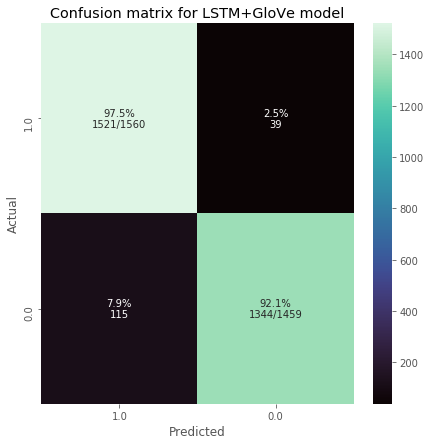

In [ ]:
#Confusion Matrix for LSTM+GloVe model
plot_cm(glove_pred, labels_glove, 'Confusion matrix for LSTM+GloVe model', figsize=(7,7))

In [ ]:
#create dataframe for lstm model with Glove embedding for predictions
submission_lstm = pd.DataFrame()
submission_lstm['id'] = test_id
submission_lstm['prob'] = lstm.predict([nlp_test, meta_test])
submission_lstm['target'] = submission_lstm['prob'].apply(lambda x: 0 if x < .5 else 1)
submission_lstm.head(5)

,id,prob,target
0,3842,0.999856,1
1,7408,0.005140,0
2,1944,0.998933,1
3,3194,0.014654,0
4,5712,0.999967,1


#### Predictions

In [ ]:
for i,j in zip(train.text.values[:10], submission_lstm['target'][:10]):
    print("Tweet to predict : ",i)
    print("The Category found is :", "[1] Depressive tweet" if j==1 else "[0] Not a Depressive tweet")
    
    

Tweet to predict :  ontd this is   best post ever unf jaredleto
The Category found is : [1] Depressive tweet
Tweet to predict :  faibw   nightrats chiffon daydream you wont be able to stop following
The Category found is : [0] Not a Depressive tweet
Tweet to predict :  
The Category found is : [1] Depressive tweet
Tweet to predict :  bgt aww i like susan boyles cat
The Category found is : [0] Not a Depressive tweet
Tweet to predict :  new follower thx u ye day weekend started friday last day nothing  mputer
The Category found is : [1] Depressive tweet
Tweet to predict :  rottenindenmark one thing study notes growing depression new deal actually pushed greatest gener
The Category found is : [1] Depressive tweet
Tweet to predict :  swagforjam natuloy din kakatapos lang kaya makirot pa i chose logos btsb first tatt  z group motivated
The Category found is : [0] Not a Depressive tweet
Tweet to predict :  weekinpictures headed into   office for ano r seo amp analytics day not been this earl

##### Thank you!